In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.ioff()
scaler = StandardScaler()

lapMatrix = pd.read_pickle("2025Silverstone2.pkl")
lapMatrix = lapMatrix.dropna(subset=[('VER', 'Lap Data')])
drivers = lapMatrix.columns.get_level_values(0).unique()
allLaps = []
allDrivers = []
palette = sns.color_palette("hls", len(drivers))
driverColours = {driver: palette[i] for i, driver in enumerate(drivers)}

columns = [
    # "throttleStd",
    "throttlePerc100",
    "throttlePerc0", 
    "avCornerBrakeDistance",  
    # "avCornerSpeedDiff",  
    # "avApexThrottle",  
    "throttleOscillation",
    # "brakeChanges",
    "coastingPerc",] 

data = {col: [] for col in columns}

In [3]:
for driver in drivers:
    driverData = lapMatrix[(driver, 'Lap Data')]
    for i in range(lapMatrix.shape[0]):
        currentDriverLap = driverData.iloc[i]
        if isinstance(currentDriverLap, dict):
            currentDriverLap.pop('avCornerSpeedDiff')
            currentDriverLap.pop('brakeChanges')
            currentDriverLap.pop('avApexThrottle')
            lapData = [currentDriverLap.get(col, None) for col in columns]
            if None not in lapData:
                allLaps.append(lapData)
                allDrivers.append(driver)
            for j, col in enumerate(columns):
                value = lapData[j]
                data[col].append({"driver": driver, "value": value})

df = pd.DataFrame({
    "driver": allDrivers,
    **{col: [row["value"] for row in data[col]] for col in columns}
})

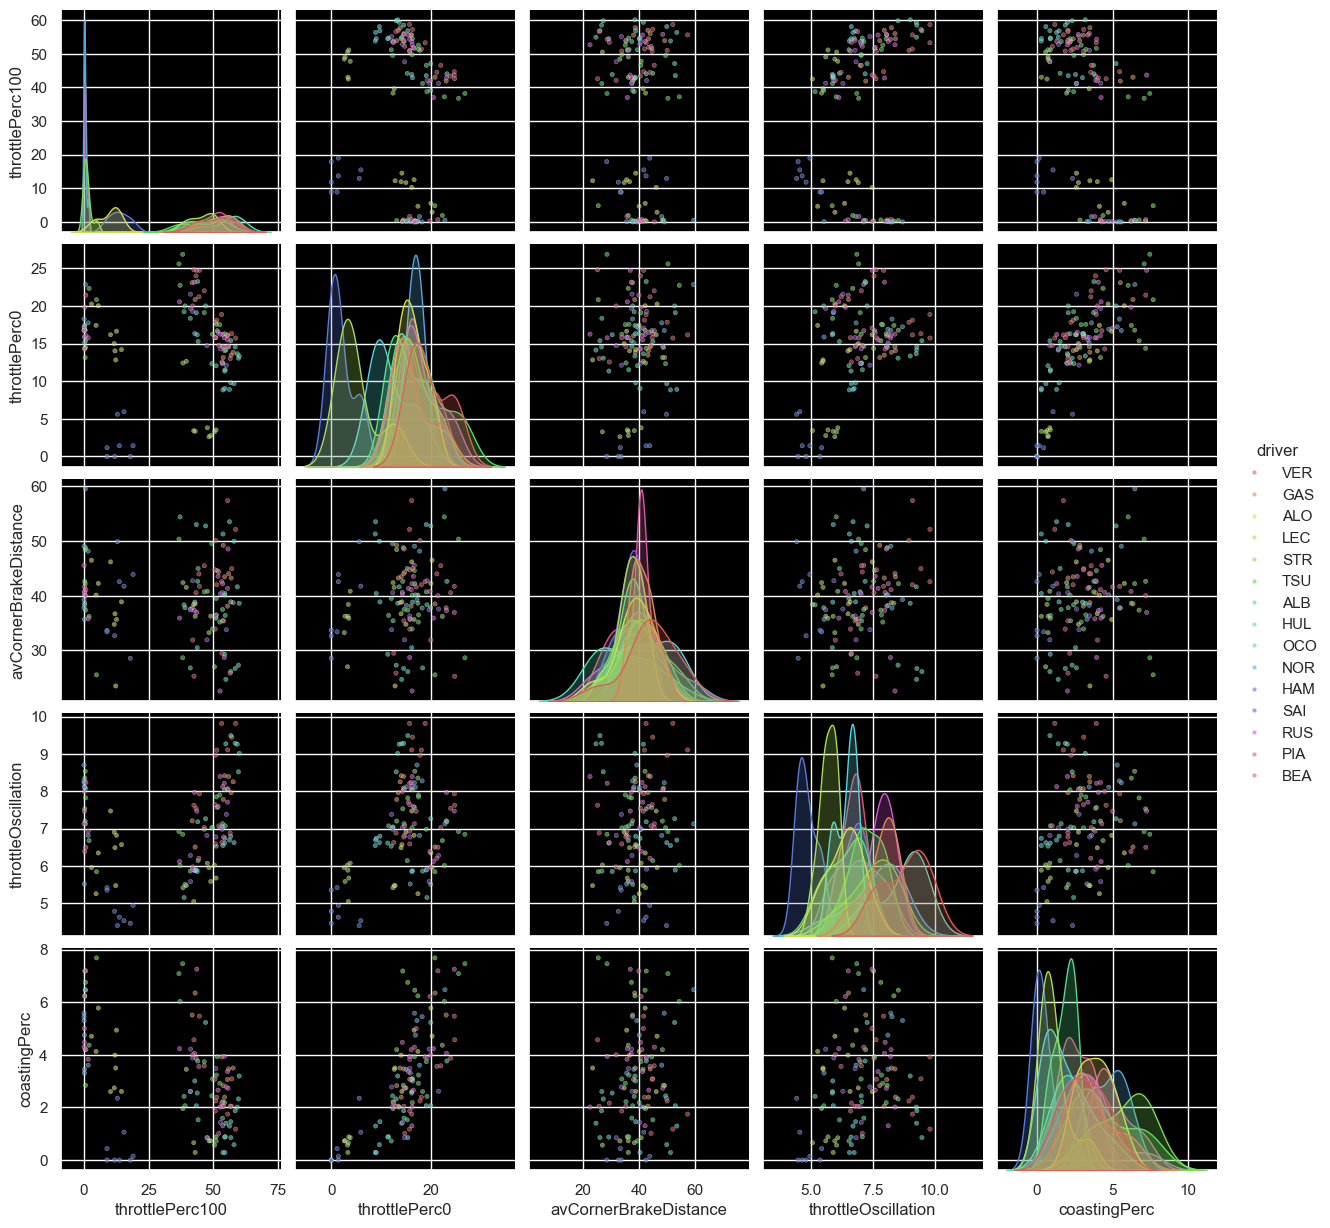

In [16]:
sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'white'})

sns.pairplot(
    df,
    vars=columns,
    hue="driver",
    palette=driverColours,
    plot_kws={"s": 10, "alpha": 0.6}
)
plt.show()

In [21]:
allLapsDF = pd.DataFrame(allLaps, columns=columns)
scaled = scaler.fit_transform(allLapsDF)
pca = PCA(n_components=0.95)
Xpca = pca.fit_transform(scaled)
hdb = HDBSCAN(min_cluster_size=5, min_samples=2,
              cluster_selection_method='leaf', metric='euclidean')
hdb.fit_predict(Xpca)
labels = hdb.labels_
df["cluster"] = labels
print(pd.crosstab(df.driver, df.cluster))
clusterSummary = df.groupby("cluster")[columns].mean()
print(clusterSummary)

cluster  -1   0   1   2   3   4   5   6   7
driver                                     
ALB       2   0   0   0   0   1   0   4   2
ALO       1   7   1   0   0   0   0   0   0
BEA       0   0   0   0   0   1   2   6   0
GAS       2   0   0   0   0   6   0   0   0
HAM       8   0   0   0   0   0   0   0   0
HUL       1   0   0   4   0   2   1   0   0
LEC       0   0   0   0   7   0   0   0   2
NOR       2   1   5   0   0   0   0   0   0
OCO       5   0   0   0   0   0   0   3   1
PIA       0   3   4   0   0   0   0   0   0
RUS       2   0   0   1   0   4   1   1   0
SAI       0   0   0   0   0   0   1   7   0
STR       1   1   6   0   0   0   0   0   0
TSU       3   0   0   0   0   4   1   1   0
VER       6   0   0   0   0   2   1   0   0
         throttlePerc100  throttlePerc0  avCornerBrakeDistance  \
cluster                                                          
-1             33.778320      14.635702              41.551515   
 0              5.693795      17.736908              3

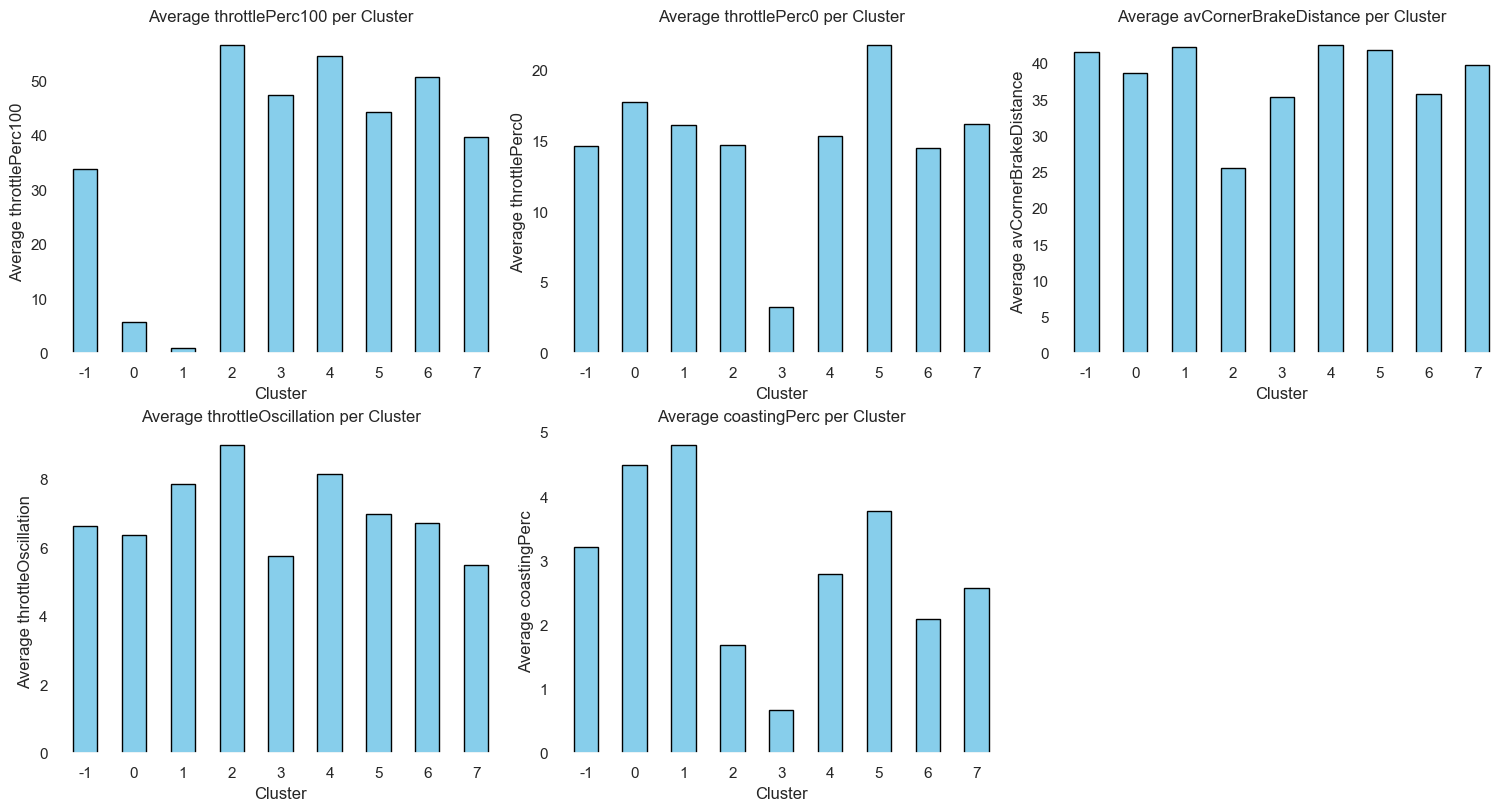

In [30]:
columns = clusterSummary.columns
nColumns = len(columns)
nRows = int(np.ceil(nColumns/3))
fig,axes = plt.subplots(nRows, 3, figsize = (15, 4*nRows),constrained_layout = True, facecolor = 'white')
if nRows == 1: axes = axes.reshape(1,-1)
axes = axes.flatten()

for index,col in enumerate(columns):
    ax = axes[index]
    clusterSummary[col].plot(kind='bar', color='skyblue', edgecolor='black',ax=ax)
    ax.set_title(f'Average {col} per Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(f'Average {col}')
    ax.set_facecolor('white')
    ax.tick_params(rotation=0)
    
for index in range(len(columns), len(axes)):
    axes[index].set_visible(False)
plt.show()

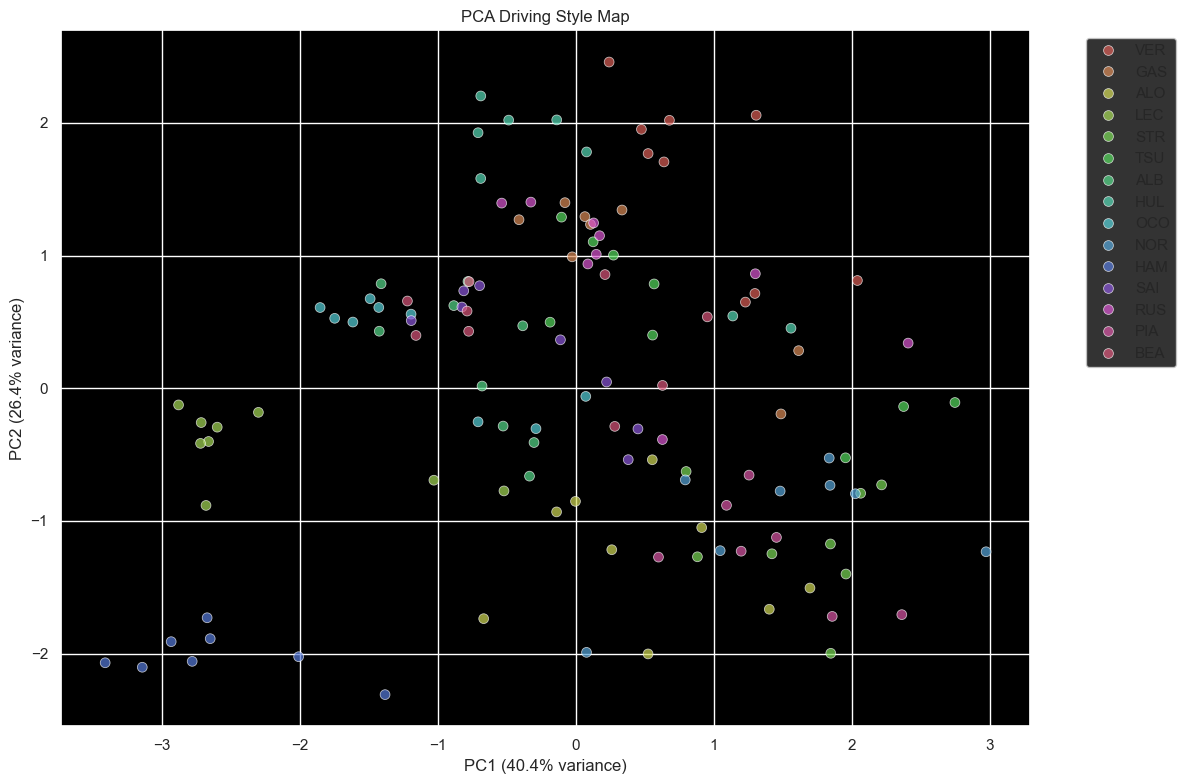

In [31]:
df['PC1'] = Xpca[:, 0]
df['PC2'] = Xpca[:, 1]

plt.figure(figsize=(12, 8))
palette = sns.color_palette("hls", len(drivers))
driverColors = {driver: palette[i] for i, driver in enumerate(drivers)}

sns.scatterplot(
    x='PC1', y='PC2',
    hue='driver',
    data=df,
    palette=driverColors,
    alpha=0.7,
    s=50
)

plt.title("PCA Driving Style Map")
plt.gca().set_facecolor('black')  
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()